# Forced Aperture Photometry

***

## Imports
We are using standard libraries from the Numpy and Astropy stack.

- `asdf` opens the Roman WFI images in the Advanced Scientific Data Format (ASDF). 
- `photutils` is an Astropy-affiliated package for photometry.
- `roman_datamodels` handles and validates data using schemas that define the expected structure of Roman data.
- `s3fs` streams data from Simple Storage Service (S3) buckets on Amazon Web Services (AWS).

In [1]:
import asdf
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import photutils
import roman_datamodels as rdm
# import s3fs

## Introduction to aperture photometry
This notebook explains how to perform **forced aperture photometry** (also known as just *forced photometry* or *aperture photometry*). Aperture photometry is useful for measuring the integrated fluxes for a set of specified source positions and aperture sizes. This technique is often valuable for extracting fluxes of known sources when it is impractical to fit for its position and light distribution, or when simplicity and speed are high priorities. For example, aperture photometry can be used for:

- **Faint sources.** If a source is too faint, then it can become difficult to fit for the source centroid, light profile, and flux.
- **Sources detected at other wavelengths.** If a source is detected at another wavelength (e.g., in another band), and the source size is expected to be the same across wavelengths, then it can be useful to define an aperture using that other wavelength in order to measure source fluxes for all wavelengths.
- **Time-series evolution of sources.** If a source brightness is decreasing over time, then we can use earlier observations to specify an aperture and extract the flux.

Here, we cover a simple example using the `photutils` package to extract fluxes from a catalog of known sources (stars and galaxies).

***

## Loading data

We obtain data from S3 buckets by using `s3fs`. **NOTE THAT THIS PART NEEDS TO BE TESTED ON THE ACTUAL SCIENCE PLATFORM BEFORE MERGING.**

### WFI image

We will load a simulated calibrated Roman WFI image in the F158 filter generated using [Roman I-Sim](https://romanisim.readthedocs.io/) using a mock source catalog of galaxies and stars (described below). This $4088 \times 4088$-pixel image covers a single detector, SCA 01. It is a Level 2 image, meaning that the up-the-ramp fitting has already been performed (along with other calibration pipeline steps), and the resulting pixel units are `DN/s`, or Digital Number per second.

In [2]:
# fs = s3fs.S3FileSystem(anon=True)
# wfi_l2_file_uri = "s3_uri_path/l2_image.asdf"

# with fs.open(wfi_l2_file_uri) as wfi_file_stream:
#     asdf_file = rdm.open(wfi_file_stream)
#     image = asdf_file.data.value
#     wcs = asdf_file.meta.wcs

wfi01_image_fname = "/grp/roman/SCIENCE_PLATFORM_DATA/ROMANISIM/DENSE_REGION/R0.5_DP0.5_PA0/r0000101001001001001_01101_0001_WFI01_cal.asdf"

asdf_file = rdm.open(wfi01_image_fname)
image = asdf_file.data.value
wcs = asdf_file.meta.wcs

### Source catalog

We also have access to a source catalog that was used to simulate the WFI image. It contains stars and galaxies, which are labeled as `PSF` and `SER` under the column `type`. Source fluxes are available in all WFI filters (`F062`, `F087`, `F106`, `F129`, `F146`, `F158`, `F184`, `F213`) and are sampled from a lognormal distribution. Note that fluxes are all given in *maggies*, which are defined as ${\rm maggie} \equiv 10^{-0.4 m_{AB}}$, for an AB apparent magnitude $m_{AB}$. 

For galaxies, morphological parameters like `n` (Sersic index), `half_light_radius`, `pa` (position angle), and `ba` (axis ratio) are also provided in the catalog. These are sampled according to fiducial (and likely unrealistic) distributions.

In [3]:
# catalog_file_uri = "s3_uri_path/catalog.ecsv"
# with fs.open(catalog_file_uri) as catalog_file_stream:
#     cat = Table.read(catalog_fname)

catalog_fname = "/grp/roman/SCIENCE_PLATFORM_DATA/ROMANISIM/DENSE_REGION/R0.5_DP0.5_PA0/fullcat_101M_pared_ra0.50_dec0.50_WFI01.ecsv"
cat = Table.read(catalog_fname)

We can also display the first five rows and all columns of the catalog:

In [4]:
cat[:5]

ra,dec,type,n,half_light_radius,pa,ba,F062,F087,F106,F129,F146,F158,F184,F213
float64,float64,str3,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
0.3766713903457873,0.4723496107078066,PSF,-1.0,0.0,0.0,1.0,2.3320517e-09,3.047865e-09,2.211402e-09,3.2631217e-10,3.2700906e-10,2.3009608e-09,5.1198396e-10,1.2950728e-09
0.3821574810146156,0.5864863951357882,PSF,-1.0,0.0,0.0,1.0,3.3980926e-10,5.53849e-09,1.3049684e-09,3.0351794e-09,9.724944e-09,9.978774e-10,1.4503033e-08,1.1672936e-09
0.5062363460695806,0.4738017969399066,PSF,-1.0,0.0,0.0,1.0,2.734704e-09,2.2499491e-09,8.982923e-09,3.0849518e-09,1.4602023e-09,5.935865e-10,2.772456e-10,1.8565122e-09
0.4724056182507333,0.5682615578430968,PSF,-1.0,0.0,0.0,1.0,6.2386847e-09,4.7599817e-09,6.4772743e-09,8.2366136e-10,4.034632e-09,2.1330218e-08,2.0134374e-09,1.493203e-09
0.4002674486158795,0.6091148239007265,PSF,-1.0,0.0,0.0,1.0,9.5673505e-09,4.4474374e-10,1.3324877e-09,3.301753e-09,2.628835e-09,7.5152684e-10,1.1272345e-08,1.6034308e-09


We can convert (RA, Dec) to (x, y) positions on the WFI 01 detector.

In [5]:
x_cat, y_cat = wcs.world_to_array_index_values(cat["ra"], cat["dec"])

It might be helpful to see how many sources there are before we try to visualize them! We first make a mask of sources that actually fall on the detector, and then divide the remaining sources into stars and galaxies.

In [6]:
on_detector_mask = (x_cat >= 0) & (x_cat <= 4095) & (y_cat >= 0) & (y_cat <= 4095)
print(f"Number of sources on detector: {sum(on_detector_mask)}")

stars = cat[on_detector_mask & (cat["type"] == "PSF")]
gals = cat[on_detector_mask & (cat["type"] == "SER")]
print(f"Number of stars: {len(stars)}\nNumber of galaxies: {len(gals)}")

Number of sources on detector: 220595
Number of stars: 218394
Number of galaxies: 2201


Note that there are two orders of magnitude more stars than galaxies! We can now plot the distribution of source fluxes using a histogram. 

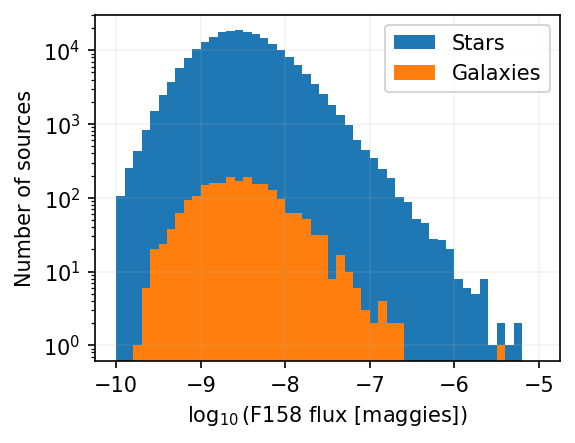

In [7]:
plt.figure(figsize=(4, 3), dpi=150)
plt.hist(np.log10(stars["F158"].value), bins=50, range=[-10, -5], log=True, label="Stars")
plt.hist(np.log10(gals["F158"].value), bins=50, range=[-10, -5], log=True, label="Galaxies")

plt.xlabel("$\log_{10}$(F158 flux [maggies])")
plt.ylabel("Number of sources")
plt.legend()

plt.grid(alpha=0.15)

## Forced aperture photometry

For simplicity, we will perform aperture photometry on a smaller sample of about 1000 stars and 1000 galaxies.

### Selection of bright stars and galaxies

We will define a limiting magnitude of $3 \times 10^{-9}$ maggies in the F158 band, and then select every 100th star and every galaxy. This will give us approximately the same number of stars as galaxies.

From the catalogs, we now know the positions for every star and galaxy. We can define set aperture radii in units of pixels; we choose radii of 3 pixels for stars and 5 pixels for galaxies.

In [8]:
limiting_flux = 3e-9

In [9]:
bright_stars = stars[(stars["F158"] > limiting_flux)][::100]
print(f"We have selected {len(bright_stars)} bright stars.")

We have selected 1068 bright stars.


In [10]:
star_positions = [(y, x) for x, y in zip(*wcs.world_to_array_index_values(bright_stars["ra"], bright_stars["dec"]))]
star_apertures = photutils.aperture.CircularAperture(
    positions=star_positions, 
    r=3
)

In [11]:
bright_galaxies = gals[gals["F158"] > limiting_flux]
print(f"We have selected {len(bright_galaxies)} bright galaxies.")

We have selected 1059 bright galaxies.


In [12]:
galaxy_positions = [(y, x) for x, y in zip(*wcs.world_to_array_index_values(bright_galaxies["ra"], bright_galaxies["dec"]))]
galaxy_apertures = photutils.aperture.CircularAperture(
    positions=galaxy_positions, 
    r=5
)

### Visualize 1/16th of simulated image

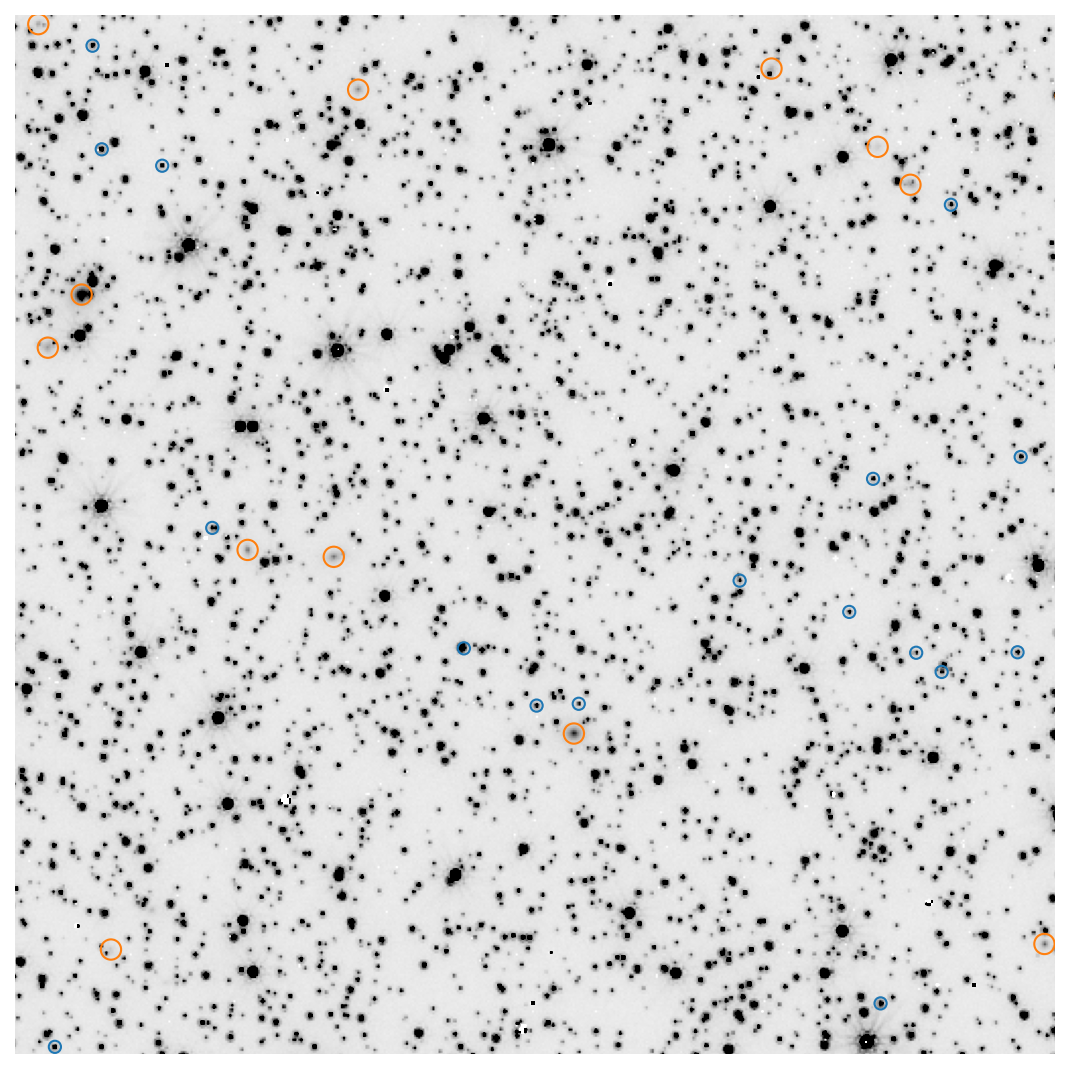

In [13]:
plt.figure(figsize=(9, 9), dpi=150)

# show the simulated image
plt.imshow(image, origin='lower', vmin=0, vmax=12, cmap="gray_r", )

# plot circles over bright galaxies and stars
star_apertures.plot(color="C0")
galaxy_apertures.plot(color="C1")

# zoom in on 1/16th of the image
plt.xlim(1024, 1536)
plt.ylim(1024, 1536)

plt.axis("off")
plt.show()

### Aperture photometry with `photutils`

In [14]:
star_phot = photutils.aperture.aperture_photometry(image, star_apertures)
star_phot[:5]

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,723.3932130910762,3129.680605282977,363.7545139701185
2,2395.90432283453,2974.5312632420864,201.03352221301608
3,519.1920103987579,2192.304976571361,202.6841968076089
4,1234.4783383607728,622.8470244737825,198.15253987307557
5,975.0151037473117,2754.3754025925587,185.97569453660688


In [15]:
galaxy_phot = photutils.aperture.aperture_photometry(image, galaxy_apertures)
galaxy_phot[:5]

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,3958.9883097230468,1865.5031007450139,142.4491018909377
2,473.68138992518493,2393.4222139494486,146.55499292209933
3,733.6632753382869,113.05665434106413,203.02321322664997
4,3203.3496882928575,2410.929586768683,319.391966342234
5,3857.0479582527946,2586.162169951734,241.68484717870334


We can now evaluate our aperture photometry! The blue points showing stars are follow a much tighter relation, which is expected given their compact sizes and smaller apertures. Meanwhile, galaxies require larger apertures, but still lose flux in some cases (for brighter galaxies) and/or are contaminated by other surrounding sources (often more noticeable for fainter galaxies).

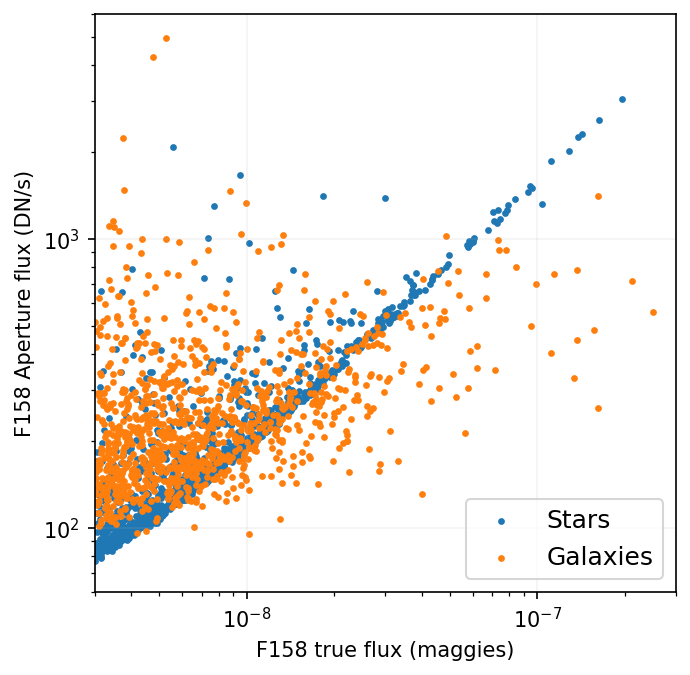

In [16]:
plt.figure(figsize=(5, 5), dpi=150)
plt.scatter(bright_stars["F158"], star_phot["aperture_sum"], s=5, c="C0", label="Stars")
plt.scatter(bright_galaxies["F158"], galaxy_phot["aperture_sum"], s=5, c="C1", label="Galaxies")

plt.xscale("log")
plt.yscale("log")
plt.xlim(3e-9, 3e-7)
plt.ylim(6e1, 6e3)

plt.xlabel("F158 true flux (maggies)")
plt.ylabel("F158 Aperture flux (DN/s)")
plt.legend(loc="lower right", fontsize=12)

plt.grid(alpha=0.15)

## Aditional Resources
The [`photutils` documentation](https://photutils.readthedocs.io/en/stable/) has additional tutorials for detecting and fitting sources in images:

- [Aperture photometry](https://photutils.readthedocs.io/en/stable/aperture.html)
- [Background estimation](https://photutils.readthedocs.io/en/stable/background.html)
- [Source detection](https://photutils.readthedocs.io/en/stable/detection.html)
- [PSF photometry](https://photutils.readthedocs.io/en/stable/psf.html)

## About this notebook

**Author:** John F. Wu (jowu@stsci.edu) 
**Updated On:** 2024-05-03

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 